In [1]:
import datetime
import os
import json
import re
from functools import partial
from itertools import count, filterfalse

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim.models import word2vec
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer

Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #2.
Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #3.


### dump and load

In [2]:
# logger
def initialize_logger(dirpath='./output/pipeline'):
    dirname = datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    os.makedirs(os.path.join(dirpath, dirname), exist_ok=True)
    
    def logger(filename, obj):    
        filepath = os.path.join(dirpath, dirname, filename)
        _, ext = os.path.splitext(filename)
        if ext == '.npy':
            np.save(filepath, obj)
        elif ext == '.json':
            json.dump(obj, open(filepath, 'w'), indent=4, ensure_ascii=False)
        else :
            raise Exception

    return logger

In [3]:
# loader
def load_log(timestamp, filename, dirpath='./output/pipeline'):
    filepath = os.path.join(dirpath, timestamp, filename)
    
    _, ext = os.path.splitext(filename)
    if ext == '.npy':
        return np.load(filepath)
    elif ext == '.json':
        return json.load(open(filepath, 'r'))
    else :
        raise Exception

### preprocessing

In [56]:
import pandas as pd
from itertools import count
import glob, os


input_train='./aozora_datasets_min/train_author_novel.csv'
df_train = pd.read_csv(input_train)
filename_author_map = dict(zip(df_train.filename, df_train.author_name))
author_label_map = dict(zip(set(df_train.author_name), count())) 


train_files = glob.glob('./aozora_datasets_min/train_datasets/*.txt')
train_filenames = list(map(os.path.basename, train_files))
train_authors = list(map(filename_author_map.get, train_filenames))

y_train = np.array(list(map(author_label_map.get, train_authors)))

In [9]:
import glob, os


train_files = glob.glob('./aozora_datasets_min/train_datasets/*.txt')
train_filenames = list(map(os.path.basename, train_files)) # doesnt reproduce result when iter is consumed
train_authors = list(map(filename_author_map.get, train_filenames))

In [10]:
y_train = np.array(list(map(author_label_map.get, train_authors)))
y

array([ 9, 13, 15, ...,  1,  5,  5])

In [ ]:
y.shape

In [57]:
df_train

,author_id,author_name,novel_id,novel_title,filename
0,162,若山 牧水,885,秋草と虫の音,885.txt
1,162,若山 牧水,2208,鮎釣に過した夏休み,2208.txt
2,162,若山 牧水,4393,一家,4393.txt
3,162,若山 牧水,2204,鴉と正覚坊,2204.txt
4,162,若山 牧水,43507,熊野奈智山,43507.txt
...,...,...,...,...,...
1584,153,石川 啄木,48150,無名会の一夕,48150.txt
1585,153,石川 啄木,49679,弓町より,49679.txt
1586,153,石川 啄木,818,弓町より,818.txt
1587,153,石川 啄木,47892,呼子と口笛,47892.txt


In [58]:
pd.concat([df_train.groupby('author_name').novel_title.nunique(),
           df_train.author_name.value_counts()], axis=1, sort=False)

,novel_title,author_name
中谷 宇吉郎,89,89
久生 十蘭,28,58
吉川 英治,57,94
坂本 竜馬,8,113
岡本 綺堂,105,182
戸坂 潤,47,47
折口 信夫,119,127
木暮 理太郎,40,40
正岡 子規,48,51
江戸川 乱歩,57,58


In [ ]:
import MeCab
import pandas as pd
import re
# from mojimoji import han_to_zen, zen_to_han
import numpy as np
from collections import Counter
from functools import partial, reduce
from itertools import chain, count, filterfalse, repeat
from operator import countOf, itemgetter, methodcaller

compose = lambda *funcs: reduce(lambda f, g: lambda *args, **kwargs: f(g(*args, **kwargs)), funcs)
flip = lambda f: lambda *args: f(*args[::-1])
pipe = flip(compose)


# str -> list
split_text_into_lines = methodcaller('splitlines')
# str -> str
convert_text_to_lowercase = methodcaller('lower')
# str -> str
replace_whitespace_with_blank_char = partial(re.sub, "\s", " ")
# str -> str
remove_whitespace = partial(re.sub, "\s", "")
# str -> str
strip_multiple_blank_chars_to_one = partial(re.sub, " +", " ")
# str -> str
strip_consecutive_chars_to_one = lambda char='ー': partial(re.sub, '{}+'.format(char), '{}'.format(char))

# str -> str
def insert_text_between_blank_chars(text, patterns):
    repls = map(" {} ".format, patterns)
    for pattern, repl in zip(patterns, repls):
        text = text.replace(pattern, repl)
    return text

# str -> str
def remove_whitespace_between_japanese_chars(text):
    """
    """
    chars = "[、。〃々〆〇ぁ-んゔゝゞァ-ンヴヵヶ・ーヽヾ一-龥]"
    pattern = "(?<={chars})\s+(?={chars})".format(chars=chars)
    repl = ""
    return re.sub(pattern, repl, text)

# str -> list
parse_tab_separated_text = re.compile("\t").split
noisy_symbols = list('!"#$%&\'()*+,-./:;<=>?@[]^_`{|}¢£¥§¨¬°±´¶×÷‐―‖"†‡‥…‰′″※℃Å←↑→↓⇒⇔∀∂∃∇∈∋−√∝∞∠∧∨∩∪∫∬∴∵∽≒≠≡≦≧≪≫⊂⊃⊆⊇⊥⌒─━│┃┌┏┐┓└┗┘┛├┝┠┣┤┥┨┫┬┯┰┳┴┷┸┻┼┿╂╋■□▲△▼▽◆◇○◎●◯★☆♀♂♪♭♯＃〈〉《》「」『』【】〒〓〔〕〜゛゜・＼／｀￣（）。、”’｀？！［］')

def maybe_lemmatize(mecab_node):
    for surface, feature in map(re.compile('\t').split, mecab_node.splitlines()[:-1]):
        if len(feature.split(',')) == 7:
            yield surface
        else:
            yield feature.split(',')[6]

def remove_noisy_symbols(raw_tokens):
    remove = dict.fromkeys(noisy_symbols, True).get
    return filterfalse(remove, raw_tokens)

preprocess = pipe(
    str,
#     han_to_zen,
#     partial(zen_to_han, kana=False),
    convert_text_to_lowercase,
    replace_whitespace_with_blank_char,
    remove_whitespace_between_japanese_chars,
    strip_consecutive_chars_to_one(),
    partial(insert_text_between_blank_chars, patterns=noisy_symbols),
    strip_multiple_blank_chars_to_one,
#     partial(re.sub, '\d', '0'),
    MeCab.Tagger().parse,
    maybe_lemmatize,
    remove_noisy_symbols,
    list
)


def tokenize_ja(path):
    with open(path) as f:
        lines = f.readlines()
        lines = [preprocess(line) for line in lines] 
        return list(chain.from_iterable(lines))

In [ ]:
data = pd.DataFrame(columns=['author', 'tokens'])

In [ ]:
data['author'] = train_authors

In [ ]:
data['tokens'] = [tokenize_ja(path) for path in train_files]

In [ ]:
data

In [ ]:
data.loc[data.isnull().any(axis=1)]

In [ ]:
# dump preprocessed data

corpus_tokenized_ja = data['tokens'].tolist()
logger = initialize_logger()
logger('corpus_tokenized_ja.json', corpus_tokenized_ja)

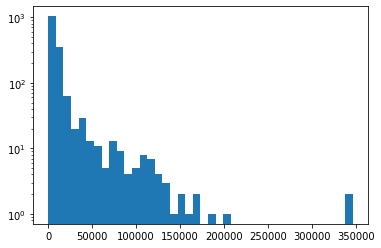

In [282]:
# overview japanese corpus
import matplotlib.pyplot as plt

corpus_tokenized_ja = load_log('20200208T072910Z','corpus_tokenized_ja.json')
len_tokens_ja = list(map(len, corpus_tokenized_ja))
plt.hist(len_tokens_ja, bins=40)
plt.yscale('log')

In [283]:
len(corpus_tokenized_ja)

1589

### vectorize

In [7]:
# get word vectors by gensim
def build_word_embedding_vectors(corpus_tokenized, word2vec_parameters):
    model = word2vec.Word2Vec(corpus_tokenized, **word2vec_parameters)
    return model, model.wv.vectors, model.wv.index2word

In [8]:
# culster word vectors by GMM
def culster_embedding_vectors(word_embeddings, gmm_parameters) -> np.ndarray:
    X = word_embeddings
    gm = GaussianMixture(**gmm_parameters)
    gm.fit(X)
    return gm.predict_proba(X)

In [9]:
# TF-IDF takes 20 min
# Use for Japanese
from collections import Counter
from itertools import chain, repeat
from operator import countOf


def build_tfidf_selfmade(corpus, vocab):
    countup = lambda doc: list(map(countOf, repeat(doc), vocab))
    tf = np.array(list(map(countup, corpus)))
    idf = np.log(len(corpus) / (tf > 0).sum(axis=0)) + 1
    return tf, idf, tf*idf

In [10]:
# TF-IDF
# cannot be used for JApanese
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf_sklearn(corpus_tokenized, vocab):
    tfv = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b', strip_accents='unicode', dtype=np.float64)
    tfv.fit(list(map(' '.join, corpus_tokenized)))
    feature_names = tfv.get_feature_names()
    idf = tfv._tfidf.idf_
    print(len(feature_names), len(idf), len(vocab))
    return np.fromiter(map(dict(zip(feature_names, idf)).get, vocab), dtype='f8')    

In [11]:
def build_word_topic_vector(word_embedding_vectors, word_cluster_probabilities, idf_vector):
    wcv = np.einsum('ij,ik->ijk', word_embedding_vectors, word_cluster_probabilities).reshape(word_embedding_vectors.shape[0], -1)
    return np.einsum('i,ij->ij', idf_vector, wcv)

In [12]:
# document vectors
def count(i=0):
    while True:
        yield i
        i+=1

def normalize_document_vectors(dv: np.ndarray) -> np.ndarray:
    dv_sum = np.square(dv).sum(axis=1)
    dv_l2norm = np.sqrt(dv_sum)
    return np.einsum('ij,i->ij', dv, 1.0/dv_l2norm)

def build_document_vectors(vocabulary, corpus_tokenized, word_topic_vectors):
    vocabulary_idx_map = dict(zip(vocabulary, count()))
    
    document_vecotrs = []
    for doc in corpus_tokenized:
        doc_idx = list(filter(lambda idx: idx is not None, map(vocabulary_idx_map.get, doc)))
        document_vecotrs.append(np.einsum('ij->j',word_topic_vectors[doc_idx]))
    
    return normalize_document_vectors(np.array(document_vecotrs))

In [13]:
# SCDV
def make_sparse(document_vectors, param):
    t = 0.5 * (np.abs(np.min(document_vectors, axis=1).mean()) + np.abs(np.max(document_vectors, axis=1).mean()))
    sparsity_threshold = param * t
    mask = np.abs(document_vectors) < sparsity_threshold
    return np.where(mask, 0.0, document_vectors)

In [214]:
corpus_tokenized = corpus_tokenized_ja_oov

In [215]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':20,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

word_embedding_vectors, vocabulary = build_word_embedding_vectors(corpus_tokenized, word2vec_parameters)

In [222]:
logger = initialize_logger()
logger('word_embedding_vectors.npy', word_embedding_vectors)
logger('vocabulary.json', vocabulary)

In [223]:
timestamp = '20200222T080552Z'
word_embedding_vectors = load_log(timestamp,'word_embedding_vectors.npy')
vocabulary = load_log(timestamp,'vocabulary.json')
word_embedding_vectors.shape, len(vocabulary)

((30640, 200), 30640)

In [ ]:
gmm_parameters = {
    'n_components':60,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}

word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

In [ ]:
logger = initialize_logger()
logger('word_cluster_probabilities.npy', word_cluster_probability_matrix)

In [ ]:
timestamp = '20200211T065328Z'
word_cluster_probability_matrix = load_log(timestamp,'word_cluster_probabilities.npy')
word_cluster_probability_matrix.shape

In [ ]:
# tf, idf, tfidf = build_tfidf_selfmade(corpus_tokenized_ja, vocabulary)

In [ ]:
# logger = initialize_logger()
# logger('tf_matrix.npy', tf)
# logger('idf_vector.npy', idf)
# logger('tfidf_matrix.npy', tfidf)

In [ ]:
tf_matrix = load_log('20200209T192435Z','tf_matrix.npy')
idf_vector = load_log('20200209T192435Z','idf_vector.npy')
tfidf_matrix = load_log('20200209T192435Z','tfidf_matrix.npy')

In [ ]:
tf_matrix.shape, idf_vector.shape, tfidf_matrix.shape

In [ ]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf_vector)
document_vectors = build_document_vectors(vocabulary, corpus_tokenized_ja, word_topic_vectors)
param = 0.04
scdv = make_sparse(document_vectors, param)

In [ ]:
# logger = initialize_logger()
logger('scdv.npy', scdv)

In [ ]:
timestamp = '20200211T065328Z'
scdv = load_log(timestamp,'scdv.npy')
scdv.shape

### classification validation with SCDV

In [ ]:
X = scdv
X.shape, y.shape

In [ ]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [ ]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [ ]:
accuracy_train

In [ ]:
accuracy_test

In [ ]:
np.average(accuracy_test)

### classification validation with TF-IDF

In [ ]:
X = tfidf_matrix
X.shape, y.shape

In [ ]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [ ]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [ ]:
accuracy_train

In [ ]:
accuracy_test

In [ ]:
np.average(accuracy_test)

## predict test data

### preprocess

In [ ]:
import glob, os


test_files = glob.glob('./aozora_datasets_min/test_datasets/*.txt')

In [ ]:
test_files

In [ ]:
author_label_map.get(filename_author_map.get('54739.txt'))

In [ ]:
# dump preprocessed data

corpus_tokenized_ja_test = data_test['tokens'].tolist()
logger = initialize_logger()
logger('corpus_tokenized_ja_test.json', corpus_tokenized_ja_test)

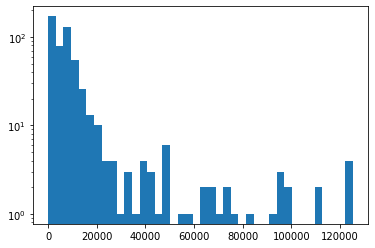

In [26]:
# overview japanese corpus
import matplotlib.pyplot as plt


corpus_tokenized_ja_test = load_log('20200213T135503Z','corpus_tokenized_ja_test.json')
len_tokens_ja = list(map(len, corpus_tokenized_ja_test))
plt.hist(len_tokens_ja, bins=40)
plt.yscale('log')

In [ ]:
data_test = pd.DataFrame(columns=['filename','tokens'])
# data_test['tokens'] = [tokenize_ja(path) for path in test_files]

In [ ]:
data_test['filename'] = list(map(os.path.basename, test_files))

In [ ]:
data_test['tokens'] = corpus_tokenized_ja_test

In [ ]:
# Nan check

data_test.loc[data_test.isnull().any(axis=1)]

In [ ]:
data_test

### vectorize test corpus by ignoring unkown tokens

In [19]:
timestamp = '20200211T051316Z'
word_embedding_vectors = load_log(timestamp,'word_embedding_vectors.npy')
vocabulary = load_log(timestamp,'vocabulary.json')
word_embedding_vectors.shape, len(vocabulary)

((30639, 200), 30639)

In [20]:
timestamp = '20200211T065328Z'
word_cluster_probability_matrix = load_log(timestamp,'word_cluster_probabilities.npy')
word_cluster_probability_matrix.shape

(30639, 60)

In [21]:
tf_matrix = load_log('20200209T192435Z','tf_matrix.npy')
idf_vector = load_log('20200209T192435Z','idf_vector.npy')
tfidf_matrix = load_log('20200209T192435Z','tfidf_matrix.npy')
tf_matrix.shape, idf_vector.shape, tfidf_matrix.shape

((1589, 30639), (30639,), (1589, 30639))

In [22]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf_vector)

In [27]:
corpus_tokenized_ja_test = load_log('20200213T135503Z','corpus_tokenized_ja_test.json')
len(corpus_tokenized_ja_test)

532

In [24]:
vocab_test = (set(chain.from_iterable(corpus_tokenized_ja_test)))
len(vocab_test)

77707

In [28]:
# scdv ignoring unknown token
document_vectors = build_document_vectors(vocabulary, corpus_tokenized_ja_test, word_topic_vectors)
param = 0.04
scdv_ignr_unk = make_sparse(document_vectors, param)
scdv_ignr_unk.shape

(532, 12000)

In [31]:
logger = initialize_logger()
logger('scdv_ignr_unk.npy', scdv_ignr_unk)

In [4]:
scdv_ignr_unk = load_log('20200222T174742Z','scdv_ignr_unk.npy')

### train classifier with training data

In [6]:
timestamp = '20200211T065328Z'
X_train = load_log(timestamp,'scdv.npy')
X_train.shape

(1589, 12000)

In [7]:
import pandas as pd
from itertools import count
import glob, os


input_train='./aozora_datasets_min/train_author_novel.csv'
df_train = pd.read_csv(input_train)
filename_author_map = dict(zip(df_train.filename, df_train.author_name))
author_label_map = dict(zip(set(df_train.author_name), count())) 


train_files = glob.glob('./aozora_datasets_min/train_datasets/*.txt')
train_filenames = list(map(os.path.basename, train_files))
train_authors = list(map(filename_author_map.get, train_filenames))

y_train = np.array(list(map(author_label_map.get, train_authors)))
y_train.shape

(1589,)

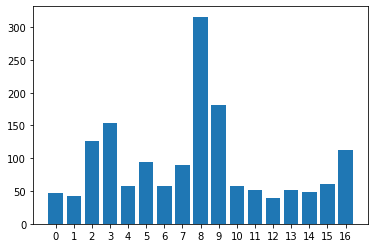

In [8]:
import matplotlib.pyplot as plt
u, counts = np.unique(y_train, return_counts=True)
plt.bar(u, counts)
plt.xticks(u);

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [19]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [21]:
# inspect prediction for validation sets

X, y = X_train, y_train

n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for val_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_val = y[val_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred_train)
    print(bas)
    
    y_pred_val = clf.predict(X_val)
    bas = balanced_accuracy_score(y_val, y_pred_val)
    print(bas)
    
    break

1.0
0.8592199803272468


([<matplotlib.axis.XTick at 0x7f426adc4290>,
 <a list of 17 Text xticklabel objects>)

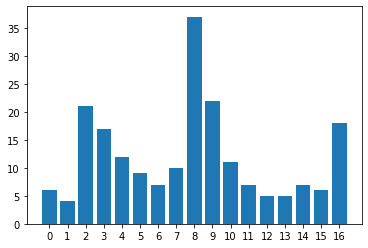

In [22]:
u, counts = np.unique(y_pred_val, return_counts=True)
plt.bar(u, counts)
plt.xticks(u)

In [23]:
# train using all the training data
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### predict test label and set author names

In [24]:
X_test = scdv_ignr_unk
X_test.shape

(532, 12000)

(array([  8.,  12.,  14.,  10.,   9.,  21.,  22.,  16.,  10.,  15.,  13.,
         13.,  18.,  16.,  20.,  33.,  25.,  29.,  52., 176.]),
 array([0.17  , 0.2115, 0.253 , 0.2945, 0.336 , 0.3775, 0.419 , 0.4605,
        0.502 , 0.5435, 0.585 , 0.6265, 0.668 , 0.7095, 0.751 , 0.7925,
        0.834 , 0.8755, 0.917 , 0.9585, 1.    ]),
 <a list of 20 Patch objects>)

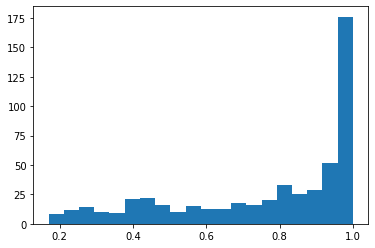

In [25]:
y_pred_proba = clf.predict_proba(X_test)
plt.hist(list(map(max, y_pred_proba)), bins=20)
# plt.hist(y_pred_proba.max(axis=1), bins=20)

In [26]:
y_pred = y_pred_proba.argmax(axis=1)

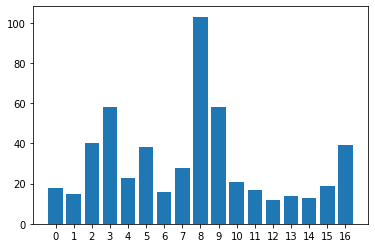

In [27]:
u, counts = np.unique(y_pred, return_counts=True)
plt.bar(u, counts)
plt.xticks(u);

In [28]:
import glob, os

path_test = glob.glob('./aozora_datasets_min/test_datasets/*.txt')
filename_test = list(map(os.path.basename, path_test))

label_author_map = dict([(v,k) for k,v in author_label_map.items()])
author_pred = list(map(label_author_map.get, y_pred))

filename_author_map_test = dict(zip(filename_test, author_pred))
filename_author_map_test

{'54740.txt': '野村 胡堂',
 '56321.txt': '野村 胡堂',
 '56201.txt': '野村 胡堂',
 '51417.txt': '坂本 竜馬',
 '49540.txt': '岡本 綺堂',
 '46139.txt': '久生 十蘭',
 '1711.txt': '戸坂 潤',
 '3578.txt': '泉 鏡花',
 '51959.txt': '坂本 竜馬',
 '56210.txt': '野村 胡堂',
 '42172.txt': '泉 鏡花',
 '46630.txt': '吉川 英治',
 '46331.txt': '折口 信夫',
 '43473.txt': '岡本 綺堂',
 '57350.txt': '正岡 子規',
 '33225.txt': '石川 啄木',
 '46070.txt': '久生 十蘭',
 '53215.txt': '中谷 宇吉郎',
 '56544.txt': '木暮 理太郎',
 '54756.txt': '野村 胡堂',
 '46148.txt': '久生 十蘭',
 '1062.txt': '岡本 綺堂',
 '55505.txt': '野村 胡堂',
 '42212.txt': '折口 信夫',
 '48255.txt': '種田 山頭火',
 '56669.txt': '江戸川 乱歩',
 '56287.txt': '野村 胡堂',
 '50771.txt': '泉 鏡花',
 '45483.txt': '岡本 綺堂',
 '55291.txt': '戸坂 潤',
 '479.txt': '岡本 綺堂',
 '54758.txt': '野村 胡堂',
 '48333.txt': '泉 鏡花',
 '48175.txt': '吉川 英治',
 '52419.txt': '吉川 英治',
 '3542.txt': '泉 鏡花',
 '45500.txt': '岡本 綺堂',
 '57109.txt': '江戸川 乱歩',
 '51931.txt': '坂本 竜馬',
 '46541.txt': '高村 光雲',
 '47502.txt': '久生 十蘭',
 '54598.txt': '野村 胡堂',
 '51923.txt': '坂本 竜馬',
 '57294.txt': '泉 鏡花

In [29]:
import pandas as pd

input_test='./aozora_datasets_min/test_author_novel.csv'
df_test = pd.read_csv(input_test)
df_test['author'] = list(map(filename_author_map_test.get, df_test['filename']))
df_test

,novel_id,filename,author
0,2198,2198.txt,若山 牧水
1,2213,2213.txt,若山 牧水
2,2627,2627.txt,泉 鏡花
3,2618,2618.txt,石川 啄木
4,2621,2621.txt,石川 啄木
...,...,...,...
527,48367,48367.txt,石川 啄木
528,48163,48163.txt,石川 啄木
529,48151,48151.txt,石川 啄木
530,48152,48152.txt,坂本 竜馬


In [30]:
output_test='./aozora_datasets_min/test_author_novel_predicted.csv'
df_test.to_csv(output_test)

### check predicted results

In [37]:
df_test.loc[200,:]

novel_id        55744
filename    55744.txt
author          野村 胡堂
Name: 200, dtype: object

In [42]:
df_test.index

RangeIndex(start=0, stop=532, step=1)

In [50]:
rng = np.random.RandomState(0)

In [ ]:
df_test.loc[rng.choice(df_test.index,10),:]

In [72]:
path_test_samples = df_test.filename.sample(10, replace=False).tolist()

In [76]:
path_test_samples

['52413.txt',
 '5058.txt',
 '57189.txt',
 '56282.txt',
 '48255.txt',
 '56264.txt',
 '56699.txt',
 '47891.txt',
 '52437.txt',
 '54579.txt']

In [77]:
list(map(filename_author_map_test.get, path_test_samples))

['吉川 英治',
 '紫式部 ',
 '江戸川 乱歩',
 '野村 胡堂',
 '種田 山頭火',
 '木暮 理太郎',
 '野村 胡堂',
 '泉 鏡花',
 '吉川 英治',
 '野村 胡堂']

In [105]:
for path in path_test_samples[5:]:
    path_test = './aozora_datasets_min/test_datasets/{}'.format(path)
    with open(path_test) as f:
        print(f.read())
    break


『嘉陵紀行』は徳川幕府の頃、三卿の一であった清水家の用人村尾正靖の著である。号を嘉陵と称した所から其《その》記行文集を『嘉陵紀行』と唱えるが、実は後人の名付けたものである。非常に旅行が好きで、暇さえあれば江戸附近の名所旧跡を探って楽しんでいたことは、其紀行文から推知することが出来る。殊に吾々に取って懐しく思われるのは、大の山岳宗徒であったことである。「府中道の記」の一節には

［＃ここから２字下げ］
　下石原、上石原などを過行。この辺路に石多し、故に石原と名付しにや。こゝより西南林木のはづれに玉川の向山見ゆ。夫より少し行て下染屋、上染屋に至る、こゝに原あり［＃割り注］上下染谷のあいだ也［＃割り注終わり］江戸よりこゝ迄は、路林木の際を出没するのみにて、目にとまるながめなく、こゝに到て初て闊達として山壑の美を見る事を得。南に大山みゆ、夫より山々連綿して富士の根を遮きり峙つ。西北を顧みれば八王子、子の権現、秩父、武甲諸山をみる。［＃割り注］こゝにて富士の根方の山々を望み、山の皺あるをみる、其やゝ近づきたるをしるべし。秩父諸山は猶更也。其外は江戸にてみるよりは高く山聳へ、富士は江戸の観にくらぶれば、根方の山にさへぎられて、五六合を見る心地す。［＃割り注終わり］玉川向山も間近くみわたされて、かたわらの民戸に腰かけてこゝの風景をうつす。
［＃ここで字下げ終わり］

という記事がある。これだけ読んでも如何に山が好きであったかが推量されるが、更に驚嘆す可《べ》きは、中仙道の桶川までわざわざ浅間山を見に出懸けた事で、其紀行の冒頭には斯《こ》う書いてある。

［＃ここから２字下げ］
　中山道上尾のあたりより、秋冬の際空晴れば、浅間の岳みゆると、過し年伊納沢吉がいひしに、いつぞは行ても見まほしく思ひしかど、仕る道のいとまなみ、今日あすともだし侍りける。今年は神無月たちぬれど、まだしぐれの雨も間遠にて、朝夕もさまで寒からねば、とみにおもひたちて寅の一点許宿を出て、火ともして行。
［＃ここで字下げ終わり］

其熱心には全く恐れ入るの外はない。而《しか》も上尾では見えなかったので、更に桶川まで行って日光赤城榛名妙義などを眺め、夢のように淡い山を見て、百姓に教えられて夫《それ》が浅間山であることを知った。

［＃ここから２字下げ］
　北の空を見渡せば、いくへの遠の雲ゐにそれかあらぬか、まゆすみ

In [103]:
filenametrain='56700.txt'
path_test = './aozora_datasets_min/train_datasets/{}'.format(filenametrain)
with open(path_test) as f:
    print(f.read())


［＃５字下げ］一［＃「一」は中見出し］

「お願いで御座いますが…………」
　振り返って見ると、同じ欄干にもたれた、乞食体《こじきてい》の中年の男、鳴海《なるみ》司郎の顔を下から見上げて、こう丁寧に申します。
　春の夜の厩橋《うまやばし》の上、更けたという程ではありませんが、妙に人足が疎《まば》らで、風体《ふうてい》の悪い人間に声をかけられると、ツイぞっとするような心淋しい晩です。
　見ると、人品骨格｜満更《まんざら》の乞食とも思えませんが、お釜帽の穴のあいたのを目深《まぶか》に、念入のボロを引っかけて、片足は鼠色《ねずみいろ》になった繃帯《ほうたい》で包み、本当の片輪かどうかはわかりませんが、怪《あや》し気《げ》な松葉杖などを突っ張って居ります。
　時も時、場所も場所、「煙草《たばこ》をくれ」か、精々「電車賃をくれ」ぐらい、よくある術《て》だと思い乍《なが》ら、鳴海司郎はかくし［＃「かくし」に傍点］へ手を入れて、軽くなった財布を引出そうとすると、
「イエイエ、お金を頂き度《た》いと申すのでは御座いません。お願いですから私の傍から少し離れて、向うの方を向いたまま、私と全く関係の無いような様子で、私の申すことを聞いて頂き度いのです」
　乞食《こじき》にしては言葉が上品で、それに言う事がヒドク変って居ります。好奇心の旺《さか》んな若い男でもなければこんな突飛な申出を、素直に聴かれるものではありませんが、鳴海司郎、幸にして年も若く、その上独り者で金こそありませんが、好奇心ならフンダンに持ち合せて居ります。社会的地位と申しますと、学校を出たての、一番下っ端の会社員で、相手が乞食《こじき》だろうが泥棒だろうが、少しも驚くことではありません。言われる通り、二三歩｜遠退《とおの》いて、灯《ともしび》の疎《まば》らな本所《ほんじょ》の河岸《かし》の方を向いたまま、
「サア、これでよかろう」
　相手になってやるぞと言わぬばかりに、後を促します。
「失礼な事を申し上げてすみませんが……何を隠しましょう、私は今重大な敵に監視されて居りますので、正面《まとも》にお話をして、貴方《あなた》に御迷惑があるといけないと思ったので御座います。こうして居る内にも、どこに、どんな眼があって、私共を見張って居るかわかりません」
　段々気味の悪いことを申しますが、その代り、この男は本当の乞食《こじき》で

In [104]:
df_train[df_train.filename == '56700.txt']

,author_id,author_name,novel_id,novel_title,filename
299,1670,野村 胡堂,56700,悪人の娘,56700.txt


# caliburate training corpus for OOV (out of vocaburaly) tokens

In [285]:
from itertools import chain
from collections import Counter
from operator import itemgetter


vocab_frequency = Counter(chain.from_iterable(corpus_tokenized_ja))
vocab_frequency_sorted = dict(sorted(vocab_frequency.items(), key=itemgetter(1), reverse=True))
# rare_tokens_freq = dict(filter(lambda x: x[1]<5, vocab_frequency.items()))
rare_tokens = set(map(itemgetter(0), filter(lambda x: x[1]<5, vocab_frequency.items())))

In [286]:
vocab_frequency_sorted

{'の': 1133951,
 'に': 729674,
 'は': 654152,
 'て': 641804,
 'た': 607187,
 'を': 573654,
 'だ': 475215,
 'が': 463738,
 'と': 408372,
 'する': 304051,
 'も': 277485,
 'ない': 223792,
 'ある': 210964,
 'で': 207899,
 'いる': 186735,
 'ます': 153012,
 'から': 137450,
 'か': 134339,
 'へ': 114927,
 'う': 101515,
 'こと': 95506,
 'お': 91816,
 'なる': 90861,
 'です': 87640,
 'れる': 83645,
 'その': 82732,
 'ん': 80949,
 'ぬ': 71304,
 'もの': 63951,
 '一': 60391,
 'よう': 60269,
 '人': 58885,
 'それ': 57608,
 'ば': 55752,
 'や': 53642,
 'この': 53026,
 '見る': 47899,
 '二': 45187,
 'という': 43039,
 '来る': 41254,
 '的': 41140,
 '中': 40562,
 'さ': 40257,
 'よ': 38624,
 '何': 37913,
 'つ': 37755,
 'つて': 36461,
 '十': 35874,
 'まで': 33296,
 'な': 32453,
 'いう': 32320,
 '三': 32198,
 '字': 32048,
 '傍点': 31876,
 'り': 31683,
 'ここ': 30772,
 '私': 30493,
 'られる': 29477,
 'そう': 28696,
 'くる': 28607,
 '日': 27830,
 'ゐる': 27792,
 '者': 27659,
 'ひる': 26615,
 'さん': 26378,
 'ので': 26258,
 '思う': 26148,
 '行く': 25638,
 '居る': 25480,
 'これ': 25233,
 '出る': 24692,
 '時': 23451,
 '上': 

In [173]:
len(rare_tokens), len(vocab_frequency)

(61333, 118900)

Text(0.5, 0, 'frequency')

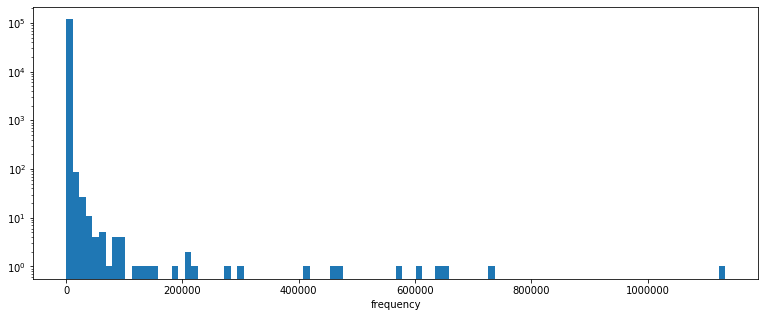

In [200]:
# frequency distribution is power distribution

plt.figure(figsize=(13,5))
plt.hist(list(map(itemgetter(1), vocab_frequency.items())), bins=100)
plt.yscale('log')
plt.xlabel('frequency')

In [175]:
probe_ratio = 0.05 # ideally, the ratio should be determined by actutal oov rate for validation set
rng = np.random.RandomState(0)

In [292]:
corpus_tokenized_ja_oov = []
for doc in corpus_tokenized_ja:
    doc_oov = []
    for token in doc:
        if token in rare_tokens and rng.rand() < probe_ratio:
            doc_oov.append('<UNK>')                
        else:
            doc_oov.append(token)

    corpus_tokenized_ja_oov.append(doc_oov)

In [293]:
# check replaced tokens as unknown
idx = 983

for i, tk in enumerate(corpus_tokenized_ja_oov[idx]):
    if tk == '<UNK>':
        print(tk, corpus_tokenized_ja[idx][i])

<UNK> 下貼り


In [294]:
len(corpus_tokenized_ja_oov)
dict00 = Counter(chain.from_iterable(corpus_tokenized_ja_oov))
dict00_sorted = dict(sorted(dict00.items(), key=itemgetter(1), reverse=True))
dict00_sorted

{'の': 1133951,
 'に': 729674,
 'は': 654152,
 'て': 641804,
 'た': 607187,
 'を': 573654,
 'だ': 475215,
 'が': 463738,
 'と': 408372,
 'する': 304051,
 'も': 277485,
 'ない': 223792,
 'ある': 210964,
 'で': 207899,
 'いる': 186735,
 'ます': 153012,
 'から': 137450,
 'か': 134339,
 'へ': 114927,
 'う': 101515,
 'こと': 95506,
 'お': 91816,
 'なる': 90861,
 'です': 87640,
 'れる': 83645,
 'その': 82732,
 'ん': 80949,
 'ぬ': 71304,
 'もの': 63951,
 '一': 60391,
 'よう': 60269,
 '人': 58885,
 'それ': 57608,
 'ば': 55752,
 'や': 53642,
 'この': 53026,
 '見る': 47899,
 '二': 45187,
 'という': 43039,
 '来る': 41254,
 '的': 41140,
 '中': 40562,
 'さ': 40257,
 'よ': 38624,
 '何': 37913,
 'つ': 37755,
 'つて': 36461,
 '十': 35874,
 'まで': 33296,
 'な': 32453,
 'いう': 32320,
 '三': 32198,
 '字': 32048,
 '傍点': 31876,
 'り': 31683,
 'ここ': 30772,
 '私': 30493,
 'られる': 29477,
 'そう': 28696,
 'くる': 28607,
 '日': 27830,
 'ゐる': 27792,
 '者': 27659,
 'ひる': 26615,
 'さん': 26378,
 'ので': 26258,
 '思う': 26148,
 '行く': 25638,
 '居る': 25480,
 'これ': 25233,
 '出る': 24692,
 '時': 23451,
 '上': 

In [309]:
for idx, ele in enumerate(dict00_sorted.items()):    
    if ele[0]=='<UNK>':
        print(idx, ele)
        n_oov = ele[1]
        break

print('oov percentage is {} %'.format(round(n_oov / sum(map(lambda x:x[1], dict00.items())) * 100, 4)))

312 ('<UNK>', 5176)
oov percentage is 0.0264 %


### vectorize test corpus by using UNK tokens

In [69]:
len(vocabulary)

30639

In [70]:
w2v_vocab_oov_map = dict(zip(vocabulary,vocabulary))

corpus_tokenized_ja_test_oov = []

for doc_test in corpus_tokenized_ja_test:
    doc_test_oov = []
    for token in doc_test:
        doc_test_oov.append(w2v_vocab_oov_map.get(token, '<UNK>'))
    corpus_tokenized_ja_test_oov.append(doc_test_oov)

len(corpus_tokenized_ja_test_oov)

532

In [73]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':20,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

word_embedding_vectors, vocabulary_oov = build_word_embedding_vectors(
    corpus_tokenized_ja_oov, word2vec_parameters)

NameError: name 'corpus_tokenized_ja_oov' is not defined

In [74]:
logger('word_embedding_vectors_oov.npy', word_embedding_vectors)

In [75]:
# timestamp = '20200222T080552Z'
# word_embedding_vectors = load_log(timestamp,'word_embedding_vectors.npy')
# vocabulary_oov = load_log(timestamp,'vocabulary_oov.json')
word_embedding_vectors.shape, len(vocabulary_oov)

((30639, 200), 30640)

In [76]:
gmm_parameters = {
    'n_components':60,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}
word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

# logger = initialize_logger()
logger('word_cluster_probabilities_oov.npy', word_cluster_probability_matrix)

In [77]:
# timestamp = '20200222T170633Z'
# word_cluster_probability_matrix = load_log(timestamp,'word_cluster_probabilities.npy')
word_cluster_probability_matrix.shape

(30639, 60)

In [ ]:
tf, idf, tfidf = build_tfidf_selfmade(corpus_tokenized_ja_test_oov, vocabulary_oov)

In [ ]:
logger('tf_matrix_oov.npy', tf)
logger('idf_vector_oov.npy', idf)
logger('tfidf_matrix_oov.npy', tfidf)

In [ ]:
word_topic_vectors = build_word_topic_vector(
    word_embedding_vectors, word_cluster_probability_matrix, idf)

### unkown words

In [330]:
w2v_vocab_oov_map = dict(zip(vocabulary_oov,vocabulary_oov))

In [252]:
w2v_vocab_oov_map = dict(zip(vocabulary_oov,vocabulary_oov))

corpus_tokenized_ja_test_oov = []

for doc_test in corpus_tokenized_ja_test:
    doc_test_oov = []
    for token in doc_test:
        doc_test_oov.append(w2v_vocab_oov_map.get(token, '<UNK>'))
    corpus_tokenized_ja_test_oov.append(doc_test_oov)

len(corpus_tokenized_ja_test_oov)

532

In [328]:
corpus_tokenized_ja_test_oov[2]

['５',
 '字',
 '下げ',
 '一',
 '一',
 'は',
 '中',
 '見出し',
 'おや',
 '八',
 '五',
 '郎',
 '親分',
 'もう',
 '御存じ',
 'で',
 '知る',
 'ない',
 'て',
 'さ',
 '隠す',
 'た',
 'って',
 '駄目',
 'だ',
 'よ',
 '真っ直ぐ',
 'に',
 '申し上げる',
 'た',
 '方',
 'が',
 'いい',
 'ぜ',
 'ガラッ',
 '八',
 'の',
 '八',
 '五',
 '郎',
 'が',
 '浜町',
 '河岸',
 'で',
 '逢う',
 'た',
 'の',
 'は',
 '廻船',
 '問屋',
 '｜',
 '浪花',
 '屋',
 'なに',
 'わや',
 'の',
 '奉公人',
 '二',
 '三',
 '本',
 '｜',
 '釘',
 'くぎ',
 'の',
 '足りる',
 'ない',
 '江戸',
 'っ子',
 'で',
 '雑用',
 'に',
 '<UNK>',
 '使う',
 'れる',
 'て',
 'いる',
 '釜',
 '吉',
 'かま',
 'きち',
 'です',
 'た',
 '五月',
 '二',
 '十',
 '八',
 '日',
 'の',
 '川開き',
 'が',
 '昨夜',
 'ゆうべ',
 '済む',
 'だ',
 'ばかり',
 '朝',
 'の',
 '浜町',
 '河岸',
 'は',
 '埃',
 '溜',
 'ごみ',
 'ため',
 'を',
 '<UNK>',
 'た',
 'よう',
 'です',
 'が',
 'その',
 '中',
 'に',
 '何かしら',
 '事件',
 'の',
 '匂い',
 'を',
 '嗅ぐ',
 'とも',
 'ない',
 '人',
 'の',
 '顔',
 'ばかり',
 'を',
 '見る',
 'て',
 '歩く',
 'て',
 '来る',
 'た',
 '八',
 '五',
 '郎',
 'だ',
 'た',
 'の',
 'です',
 '恐れ入る',
 'た',
 'ネ',
 '八',
 '五',
 '郎',
 '親分',
 'あれ',
 'を',
 '御存じ',
 'と',
 'は',
 '何

In [253]:
dict01 = Counter(chain.from_iterable(corpus_tokenized_ja_test_oov))

In [254]:
len(dict01)

29721

In [255]:
dict01.get('<UNK>')

142555

In [279]:
dict01_sorted = dict(sorted(dict01.items(), key=itemgetter(1), reverse=True))
dict01_sorted

{'の': 348549,
 'に': 219741,
 'は': 203729,
 'て': 193749,
 'た': 185908,
 'を': 176210,
 'だ': 144754,
 '<UNK>': 142555,
 'が': 139643,
 'と': 124463,
 'する': 92832,
 'も': 85265,
 'ない': 65554,
 'ある': 65470,
 'で': 62924,
 'いる': 56516,
 'ます': 48471,
 'か': 41517,
 'から': 40793,
 'へ': 34823,
 'う': 30860,
 'です': 30382,
 'こと': 29936,
 'なる': 27483,
 'ん': 27255,
 'お': 25859,
 'その': 25608,
 'れる': 24882,
 'ぬ': 21402,
 'もの': 20406,
 'よう': 19150,
 '人': 18239,
 '一': 18145,
 'それ': 16936,
 'や': 16607,
 'この': 16358,
 'ば': 16141,
 '見る': 14495,
 '二': 14301,
 'という': 13548,
 'よ': 12377,
 '中': 12319,
 'さ': 12152,
 '十': 12124,
 '来る': 11816,
 '何': 11268,
 '的': 11062,
 'つて': 10528,
 'つ': 10505,
 'まで': 10038,
 'いう': 9989,
 'な': 9832,
 '三': 9821,
 'ここ': 9249,
 'り': 9131,
 'くる': 9017,
 '字': 8878,
 'られる': 8761,
 'そう': 8753,
 '者': 8419,
 '私': 8371,
 'ひる': 8122,
 '思う': 8113,
 'これ': 8067,
 '日': 7927,
 '居る': 7882,
 'ゐる': 7879,
 '彼': 7873,
 'ので': 7676,
 '出る': 7599,
 '行く': 7482,
 'など': 7385,
 '時': 7268,
 '五': 7267,
 'さん': 7155,

In [311]:
for idx, ele in enumerate(dict01_sorted.items()):    
    if ele[0]=='<UNK>':
        print(idx, ele)
        n_oov = ele[1]
        break

print('oov percentage is {} %'.format(round(n_oov / sum(map(lambda x:x[1], dict01.items())) * 100, 4)))

7 ('<UNK>', 142555)
oov percentage is 2.3779 %


In [325]:
pd.Series(sorted(map(Counter(chain.from_iterable(corpus_tokenized_ja)).get, set(train_vocab).difference(set(test_vocab))))).value_counts().sort_index()

1      30706
2       8862
3       4375
4       2470
5       1724
       ...  
329        1
356        1
366        1
380        1
497        1
Length: 154, dtype: int64

In [287]:
train_vocab = set(chain.from_iterable(corpus_tokenized_ja))
train_vocab_map = dict(zip(train_vocab, train_vocab))
len(train_vocab_map)

118900

In [320]:
test_vocab = set(chain.from_iterable(corpus_tokenized_ja_test))

set(train_vocab).difference(set(test_vocab))

{'総なめ',
 '八重十文字',
 '繩文',
 'ワカッタカ',
 'ぐわにるゐす',
 'びにかこまれてこまっていた',
 'タルモノナシト',
 '引き際',
 'ょうげんときます',
 'mistake',
 '上川盆地',
 'ぎだつたのです',
 '馴君',
 'topos',
 '加代',
 '錯落',
 '馴鹿',
 '來歌',
 'コンタツ',
 'フワーッ',
 '模擬',
 '抄略',
 'ミラネェゼ',
 '晝買',
 'kraftwirkung',
 'びにかけあがっていきます',
 'オキナ',
 'ゃべりまくられたかたちで',
 '藪川',
 'ゃらひゅで',
 '寶塔',
 '違外',
 'ホウギョッカン',
 'モルドー',
 '有高',
 '其替',
 'ぺしょった',
 'part',
 '舊御',
 'ゑてゐて',
 'es',
 '無品',
 'むりたまへり',
 'づるゆき',
 'づめの',
 'ノオブリイ',
 'ブルジョワ',
 'カンパニエール',
 'オベベ',
 'ヤマモト',
 '駻婦',
 '鉢ヶ峰',
 '神祭',
 '檮岡',
 '刷りこむ',
 '鷲羽岳',
 'ざっぱいざんまい',
 'ぱだかなり',
 '霰模',
 '関破り',
 '原点',
 '差止める',
 '臘山',
 '惡評',
 'ニュースヴァリュー',
 '並一通り',
 '以詔',
 '掻い込む',
 'ニフ',
 '其封',
 '消防車',
 '181',
 '一沙',
 '蓄電器',
 'produkt',
 '貌診',
 '集魚',
 '雲烟',
 'ウェーター',
 '躊',
 'センメツ',
 'ツウロン',
 'domestic',
 'グレッフェ',
 '絵入り',
 'デンツク',
 '伝蔵',
 '姦臣',
 '來椿',
 '移駐',
 'コンヴェーヤーシステム',
 'グウズ',
 '特飲街',
 'びぜんのかみ',
 '牧口',
 '方口',
 'geburtstag',
 '万国博覧会',
 '図示',
 '即諾',
 'gegenwart',
 'ぐはし',
 'ミブ',
 'キャトールズ',
 'むちゅうになっていた',
 'びっこで',
 '曽田',
 '箇附',
 '此伊',
 '脅腹',
 '弼憲

In [288]:
train_vocab_map.get('<UNK>')

In [289]:
corpus_tokenized_ja_test_oov02 = []

for doc_test in corpus_tokenized_ja_test:
    doc_test_oov = []
    for token in doc_test:
        doc_test_oov.append(train_vocab_map.get(token, '<UNK>'))
    corpus_tokenized_ja_test_oov02.append(doc_test_oov)

# len(corpus_tokenized_ja_test_oov02)
dict02 = Counter(chain.from_iterable(corpus_tokenized_ja_test_oov02))
dict02_sorted = dict(sorted(dict02.items(), key=itemgetter(1), reverse=True))
dict02_sorted

{'の': 348549,
 'に': 219741,
 'は': 203729,
 'て': 193749,
 'た': 185908,
 'を': 176210,
 'だ': 144754,
 'が': 139643,
 'と': 124463,
 'する': 92832,
 'も': 85265,
 'ない': 65554,
 'ある': 65470,
 'で': 62924,
 'いる': 56516,
 'ます': 48471,
 'か': 41517,
 'から': 40793,
 'へ': 34823,
 'う': 30860,
 'です': 30382,
 'こと': 29936,
 'なる': 27483,
 'ん': 27255,
 'お': 25859,
 'その': 25608,
 'れる': 24882,
 '<UNK>': 23334,
 'ぬ': 21402,
 'もの': 20406,
 'よう': 19150,
 '人': 18239,
 '一': 18145,
 'それ': 16936,
 'や': 16607,
 'この': 16358,
 'ば': 16141,
 '見る': 14495,
 '二': 14301,
 'という': 13548,
 'よ': 12377,
 '中': 12319,
 'さ': 12152,
 '十': 12124,
 '来る': 11816,
 '何': 11268,
 '的': 11062,
 'つて': 10528,
 'つ': 10505,
 'まで': 10038,
 'いう': 9989,
 'な': 9832,
 '三': 9821,
 'ここ': 9249,
 'り': 9131,
 'くる': 9017,
 '字': 8878,
 'られる': 8761,
 'そう': 8753,
 '者': 8419,
 '私': 8371,
 'ひる': 8122,
 '思う': 8113,
 'これ': 8067,
 '日': 7927,
 '居る': 7882,
 'ゐる': 7879,
 '彼': 7873,
 'ので': 7676,
 '出る': 7599,
 '行く': 7482,
 'など': 7385,
 '時': 7268,
 '五': 7267,
 'さん': 7155,


In [291]:
len(corpus_tokenized_ja_test_oov02)

532

In [312]:
for idx, ele in enumerate(dict02_sorted.items()):    
    if ele[0]=='<UNK>':
        print(idx, ele)
        n_oov = ele[1]
        break

print('oov percentage is {} %'.format(round(n_oov / sum(map(lambda x:x[1], dict02.items())) * 100, 4)))

27 ('<UNK>', 23334)
oov percentage is 0.3892 %


In [314]:
sum(map(lambda x:x[1], dict02.items()))

5994976

#### train w2v

In [335]:
# get word vectors by gensim
def build_word_embedding_vectors(corpus_tokenized, word2vec_parameters):
    model = word2vec.Word2Vec(corpus_tokenized, **word2vec_parameters)
    return model

In [336]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':10,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

model = build_word_embedding_vectors(corpus_tokenized_ja_oov[:20], word2vec_parameters)
word_embedding_vectors = model.wv.vectors
w2v_vocabulary_oov = model.wv.index2word

In [355]:
len(w2v_vocabulary_oov)

1542

In [343]:
model.wv.most_similar('<UNK>')

[('べし', 0.47428154945373535),
 ('なす', 0.46077266335487366),
 ('あか', 0.45489370822906494),
 ('博士', 0.44758546352386475),
 ('為', 0.43521201610565186),
 ('歌', 0.4178161025047302),
 ('都', 0.41288331151008606),
 ('成す', 0.40964460372924805),
 ('葉', 0.40924713015556335),
 ('別', 0.4091378450393677)]

In [353]:
gmm_parameters = {
    'n_components':60,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}
word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

In [357]:
tf_matrix, idf_vector, tfidf_matrix = build_tfidf_selfmade(corpus_tokenized_ja_oov[:20], w2v_vocabulary_oov)

In [358]:
tf_matrix.shape, idf_vector.shape, tfidf_matrix.shape

((20, 1542), (1542,), (20, 1542))

In [359]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf_vector)

In [363]:
word_topic_vectors.shape

(1542, 12000)

#### vectorize test

In [360]:
w2v_vocabulary_oov_set = set(w2v_vocabulary_oov)

In [361]:
corpus_tokenized_ja_test_oov = []

for doc_test in corpus_tokenized_ja_test[:5]:
    doc_test_oov = []
    for token in doc_test:
        if token not in w2v_vocabulary_oov_set:
            doc_test_oov.append('<UNK>')
        else:
            doc_test_oov.append(token)
    
    corpus_tokenized_ja_test_oov.append(doc_test_oov)

len(corpus_tokenized_ja_test_oov)

5

In [376]:
# scdv taking into account <UNK> token
document_vectors = build_document_vectors(w2v_vocabulary_oov, corpus_tokenized_ja_test_oov, word_topic_vectors)
param = 0.04
scdv_oov = make_sparse(document_vectors, param)
scdv_oov.shape

(5, 12000)

In [378]:
list(map(sum,scdv_oov))

[-0.9370807712792679,
 -0.7781215039263045,
 -0.5960455746851921,
 -0.821067320458324,
 -0.7648495469651619]

In [377]:
# scdv ignoring unknown token
document_vectors = build_document_vectors(w2v_vocabulary_oov, corpus_tokenized_ja_test[:5], word_topic_vectors)
param = 0.04
scdv_oov_ign = make_sparse(document_vectors, param)
scdv_oov_ign.shape

(5, 12000)

In [379]:
list(map(sum,scdv_oov_ign))

[-0.31600351608182986,
 0.12559320596954246,
 0.16306114157021934,
 0.09787337635741764,
 0.08571247839288908]

In [ ]:
list(range(17))

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
len(y_pred), len(X_test)

In [ ]:
u, counts = np.unique(y_pred, return_counts=True)
plt.bar(u, counts)

In [ ]:
y_pred